In [1]:
import os
import sys
import time
import serial
import serial.tools.list_ports
import datetime #as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit
import math

from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy import signal
from scipy.stats import alexandergovern
from scipy.stats import kruskal
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from scipy.stats import lognorm
from scipy.stats import f as fSnedecora
import statistics

In [2]:
'''Wskazanie miejsca zapisu próbek, nazw plików csv i numerów grup'''

dir='D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/'
numberOfGroup=[3,5,7,9]
disp='test.csv'
force='ID00_CH00_WeightScale2kN.csv'
volt='ID01_CH00_Analog1.csv'

global dir_img
dir_img='D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/img/'

In [3]:
class ChangeDataNames:
    '''
    class responsible for renaming columns and data format
    for 2 dataframe: 
    'Mass [g]': 'Force' and 'Voltage [mV]': 'Voltage'
    
    using Sawwicki Golaya filter for to eliminate measurement disturbances (saw signal)
    '''
    
    def __init__(self,df_force,df_volt):
        self.df_force=df_force
        self.df_volt=df_volt
        
    def correctDataAndName(self,area):

        self.df_force=self.df_force.rename(columns={'Mass [g]': 'Force', "time [ms]": 'timeF'})
        self.df_volt=self.df_volt.rename(columns={'Voltage [mV]': 'Voltage', "time [ms]": 'timeV'})
        
        
        self.df_force.Force=self.df_force.Force*0.0098105 
        
        
        '''Sawicki Golaya'''
        #self.df_force.Force=Calculus.averagingFilter(self.df_force.Force,3)
        window_length=5
        polyorder=2 #less then window
        self.df_force.Force=signal.savgol_filter(self.df_force.Force, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        
        self.df_force.timeF=self.df_force.timeF/1000
        self.df_volt.timeV=self.df_volt.timeV/1000
        self.df_force['Stress']=self.df_force.Force/area
        self.df_volt.Voltage=self.df_volt.Voltage#/area

            

        self.df_force.Force=self.df_force.Force-self.df_force.Force.iloc[0]
            #df2[dfForceName]=df2[dfForceName].ewm(com = 0.4).mean()
        self.df_force.reset_index(drop=True) 
        self.df_volt.reset_index(drop=True)

        dfnew=pd.concat([self.df_volt, self.df_force.reindex(self.df_volt.index)], axis=1)
        
        return dfnew
    
    
    
class SubData:
    '''
    class preparing artificial set of data
    
    in this case set 
    '''
    def __init__(self):
        pass
    @staticmethod    
    def shortExtensions(R):
        sExtensions=pd.DataFrame({ 'A' : range(0,R,1)})
        #czas rozciagania to 3sekundy i próbkowanie = 20sample/s stąd 60
        sExtensions=sExtensions['A']
        sExtensions=sExtensions/10/100
        return sExtensions

class CutterDF(SubData):
    '''
    class with methods to extrcat specific part of data from the entire waveform 
    '''
    def __init__(self,df):
        self.df=df
        
    def idOfMaxStress(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        maxIdForce=[(self.df.loc[stressRanges[i*2]:stressRanges[i*2+1], 'Stress'].idxmax()) 
                    for i in range (int(len(stressRanges)/2))]   
        return maxIdForce
    
    def cutPartOfRange(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        #dfshort=self.df.Stress[maxIdForce1-60:maxIdForce1].reset_index(drop=True)
        
        dfshort=[(self.df.Stress[stressRanges[i*2]:stressRanges[i*2+1]].reset_index(drop=True)) 
                 for i in range (int(len(stressRanges)/2))] 

            
        
        #dfshort=dfshort.iloc[::-1]
        return dfshort            

    
class Calculus(SubData):
    
    '''
    class with methods for mathematical calculation
    
    1. calculates a straight line which is to be 
    an approximation of the course and its coefficient 
    a from the formula y = ax + b corresponds to the elasticity modulus
    
    2. averaging filter
    
    3. calculates deriattive of wavefrom
    
    '''
    def __init__(self):   
        pass

    
    @staticmethod    
    def funcYoung(e,a,b): #współczynnik szybkości relaksacji
        return a*e+b
    @staticmethod    
    def youngFunc(e,s):
    

        #print(e.head(-5))
        #print(s.head(-5))
        plt.figure(figsize=(7,3))

        plt.plot(e,s)
        popt, _ = curve_fit(Calculus.funcYoung, e, s, method='lm')
        a, b=popt
        #print(popt)

        plt.plot(e,s)
        plt.plot(e, Calculus.funcYoung(e, *popt), 'g--') #funkcja pokazująca dopasowane expFunc do rzeczywistej
        #plt.legend()
        plt.show()
        return a
    @staticmethod
    def averagingFilter(interval, window_size):
        window = np.ones(int(window_size))/float(window_size)
        return np.convolve(interval, window, 'same') 
    
    '''Check diffrent methods for deriattive'''
    @staticmethod
    def deriattiveDf(x,y):
        d=np.zeros(len(x))
        for i in range(1,len(x)-1):
            d[i]=((x[i+1]-x[i-1])/(y[i+1]-y[i-1]))
            d[0]=d[1]
            
        return d

        
class Ploting(Calculus):
    '''
    class with methods for plottig
    
    1. plotting for histeresis
    2. plotng for boxplot
    
    '''
    def __init__(self):
        pass
    
    def plot_histeresis(self,stress_1,stress_2,xlabel,ylabel,title,label_1,label_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        stress_2=stress_2.iloc[::-1] #odwrócenie drugiego przebiegu

        plt.figure(figsize=(8,5))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.plot(extension,stress_1, label=label_1)
        plt.plot(extension,stress_2, label=label_2)
        plt.fill_between(extension, stress_1, stress_2, color='b', alpha=0.2, hatch='/')
        plt.legend()
        plt.show()  
        pass
    def plot_boxScatterdf(self,df,name_1,ylabel,title,ylim_1=0,ylim_2=300):
        noG=df.columns
        name=''.join(noG)
        name=name+'_'+name_1+'_boxplot'
        plt.figure()
        df.boxplot()
        for i, d in enumerate(df):
            y = df[d]
            x = np.random.normal(i + 1, 0.04, len(y))
            plt.scatter(x, y)
        #plt.ylim(10,70)
        plt.ylim(ylim_1,ylim_2)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.savefig(dir_img+name+'.pdf', dpi=300)
        plt.show()
    def plotData(self,b):
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('Stress [MPa]', color=color)
        ax1.plot(b.timeF, b.Stress, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Voltage [mV]', color=color)  # we already handled the x-label with ax1
        ax2.plot(b.timeV, b.Voltage, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
class StaticCalculus(SubData):
    def __init__(self):   
        pass    
    '''
    class with methods for mathematical calculation for statistic
    
    Annov + Test Studenta (tTest)
    
    '''

    @staticmethod    
    def normalDis(df):
        #listoflists=[]
        for col in df.columns:
            l=dfY[col].tolist()
            stats, p = shapiro(l)
            print(col,stats,p)
            #print(col)
            if p > 0.05:
                print ("Rozkład wygląda na normalny")
            else:
                print('Nienormalny')
            sns.distplot(l)
            #fig, ax = plt.subplots(1, 1)
            #shape, location, scale = stats.lognorm.fit(l)
            #mu, sigma = np.log(scale), shape
            plt.show()
            #listoflists.append(l)
            #print(listoflists[0])

    @staticmethod    
    def annovaTest(df,name_1):
        G=[]         
        for i in list(df.columns):
            g = [x for x in df[i].tolist() if str(x) != 'nan']
            G.append(g)
            #print(G)
        MSTR=0
        MSE=0

        meanG=0
        n=0
        for i in range(len(G)):
            n=n+len(G[i])
            meanG=meanG+sum(G[i])
        meanG=meanG/n
        #print(meanG)

        for i in range(len(G)):
            #print(i)
            meanGi=statistics.mean(G[i])
            SSbetween_group=len(G[i])*(meanGi-meanG)**2
            MSTR=MSTR+SSbetween_group
            #print(meanGi)
            for j in range(len(G[i])):
                SSwithin_group=(G[i][j]-meanGi)**2
                MSE=MSE+SSwithin_group


                #print(j)

        MSTR=MSTR*(1/(len(G)-1))        
        MSE=MSE*(1/(n-len(G)))
        F=MSTR/MSE

        p=fSnedecora.sf(F, len(G)-1, n-len(G)) # F Snedecora 
        #lewo i prawo brzeżnie

        #s,p=f_oneway(G[0],G[1],G[2],G[3])
        #print('pvalue = '+str(p)+'\n')
        print('pvalue = '+str(p)+' F='+str(F)+'\n')
        if p<0.12:
            print('p<0.05\n')
            StaticCalculus.postHocTest(df,name_1)

    @staticmethod    
    def postHocTest(df,name_1):
        x=[]
        j=0
        k=0
        #print(df.stack())
        noG=df.columns
        df.columns.name = 'var_name'
        name=''.join(noG)
        name=name+'_'+name_1+'_TTest'
        #x=df.stack()
        #x.name = 'val'
        #x.reset_index()
        #x.rename(columns={[0]: 'groups', [1]: 'val'}, inplace=True)
        x=pd.melt(df.reset_index(), value_vars=noG, var_name='var_name', value_name='value')
        x.dropna(subset = ["value"], inplace=True)
        #print(x)
        '''
        for i in list(df.columns):

            g = [x for x in df[i].tolist() if str(x) != 'nan']
            x.append(g)
            k=k+j # poprawka Bonferroniego https://pl.wikipedia.org/wiki/Poprawka_Bonferroniego
            j=j+1 # Bonferroniego
            #print(k)
        '''
        
        print('Anderson bez poprawki Bonferroniego')
        print(sp.posthoc_anderson(x,val_col='value', group_col='var_name'))
        print('Ttest bez poprawki Bonferroniego')
        
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name'))
        print('Ttest z poprawką Bonferroniego')
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni'))
        #print(k)
        plt.figure()
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        pc=sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni')  # *k - Bonferroniego
        sp.sign_plot(pc, **heatmap_args)
        plt.savefig(dir_img+name+'.pdf', dpi=300)
        plt.show()

class Parameters(Calculus,SubData):
    '''
    Main class
    with set od methods to return:
    
    young - elastic modulus
    
    dropOfStress -  the value of stress of subtract difference between:
                    first peak, and point od end of relaxation
    
    areaOfHisteresis - area of histeresis
    
    dropOfElasticModulus - drof of elastic modulus between first and second extension: 
                           dropOfYoung=((young1 - young2)/young1)*100[%]
                           
    voltMax - return max voltage value
    
    inflectionPoint - to calculating point of inflection
    
    '''
    def __init__(self,df):
        self.df=df
        
    def young(self,shortStress,rangeOfStraight):

        shortStress=shortStress[-rangeOfStraight:]    
        extension=SubData.shortExtensions(rangeOfStraight)
        modulYounga=Calculus.youngFunc(extension,shortStress)
        return modulYounga
        
    def dropOfStress(self,maxIdForce,endRel):

        dropStress=((self.df.Stress.iloc[maxIdForce]-self.df.Stress.iloc[endRel])/self.df.Stress.iloc[maxIdForce])
        
        return dropStress
    
    def areaOfHisteresis(self,stress_1,stress_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        
        area1=np.trapz(stress_1.to_numpy(), x=extension.to_numpy())
        area2=np.trapz(stress_2.to_numpy(), x=extension.to_numpy())
        
        print(area1)
        print(area2)
        histeresis=(area1-area2)/area1
        return histeresis
    
    def dropOfElasticModulus(self,young1,young2):
        dropOfYoung=((young1 - young2)/young1)*100
        return dropOfYoung
    
    def voltMax(self,z1,z2):
        maxVolt = self.df.Voltage.loc[int(z1):int(z2)].max()
        return maxVolt

    def inflectionPoint(self,stress,rangeOfStraight):
        stress=stress[-rangeOfStraight:]
        extension=SubData.shortExtensions(rangeOfStraight)
        
        window_length=31#rangeOfStraight-29
        polyorder=7 #less then window #1
        plt.plot(stress)
        stress=signal.savgol_filter(stress, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        ds_1=Calculus.deriattiveDf(extension,stress)
        window_length=7
        polyorder=1 #less then window        
        #ds_1=signal.savgol_filter(ds_1, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        
        #ds_2=Calculus.deriattiveDf(extension[:-1],ds_1)
        #window_length=7
        #polyorder=1#less then window        
        #ds_2=signal.savgol_filter(ds_2, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        #dff=Calculus.deriattiveDf(extension,Calculus.deriattiveDf(extension,stress))
        '''
        plt.plot(stress)
        plt.show()

        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        #plt.plot(ds_2)
        #plt.show()
        #'''
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.012)
        
        
        '''
        Znajdz mediane dla przebiegu ostatnich 5-10 punktow jakos i wyzeruj 
        wzglem niej  a potem warunek jak na górze
        
                
        most_common = max(list(ds_1[-10:-1]), key = list(ds_1).count)
        print(most_common)
        ds_1=ds_1-most_common
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.05)
        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        
        '''
        #print(60-p)
        return p

[430, 12594, 12413]


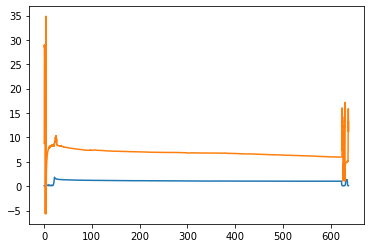

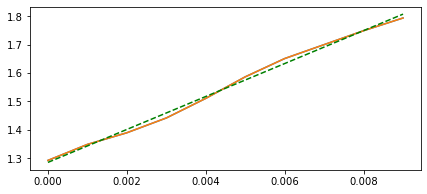

57.979718159826675


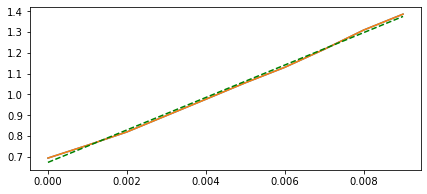

77.88860829199949


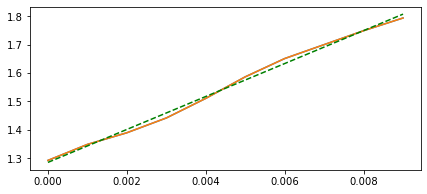

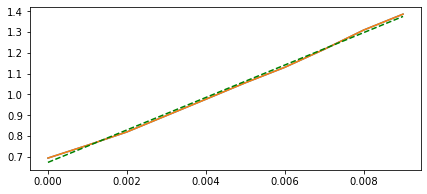

-34.33768007856134
0.04357175836393542
0.014071710305337088
0.6770451587516303
0.02026799878015642
nan
nan
0.04357175836393542
0.02026799878015642
0.5348363357093169
0.4449510337774391
59
56
34.853
6.965


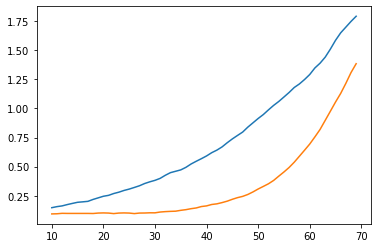

In [4]:
df0= pd.read_csv ('g1.csv')
#strGroup='1'

newDir=dir+'G109/'
try:
    dfarea=df0['g109.STL'].nsmallest(50)
except:
    dfarea=df0['G109.STL'].nsmallest(50)
#try:
#    dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
#except:
#   dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
area=dfarea.mean()

df2 = pd.read_csv (newDir+force, delimiter=';',decimal=',')
df3 = pd.read_csv (newDir+volt, delimiter=';',decimal=',')  

a=ChangeDataNames(df2,df3)
b=a.correctDataAndName(area)
    
#print(b)

c=CutterDF(b)

d=c.idOfMaxStress(0,4000,12500,14000)
#                 first peak,second peak, end of first relaxation
d=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
print(d)
#print(e)
e=d
print(c)
            #afe=dfnew[dfStressName][maxIdForce1-60:maxIdForce1].reset_index(drop=True)
            #afr=dfnew[dfStressName][end_fisrtRel:end_fisrtRel+60].reset_index(drop=True)
            #ase=dfnew[dfStressName][maxIdForce2-60:maxIdForce2].reset_index(drop=True)
            #asr=dfnew[dfStressName][maxIdForce2+60:maxIdForce2+120].reset_index(drop=True)
f=c.cutPartOfRange(e[0]-70,e[0],e[2],e[2]+70,e[1]-70,e[1],e[1]+70,e[1]+140)
#print(f)
h=Calculus()

plt.plot(b.timeF,b.Stress)
plt.plot(b.timeV,b.Voltage)
plt.show()


#plot_histeresis(stress_1,stress_2,extension,xlabel,ylabel,title,label_1,label_2)


l=Parameters(b)

print(l.young(f[0],10))
print(l.young(f[2],10))
print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

print(l.areaOfHisteresis(f[0],f[1]))
print(l.areaOfHisteresis(f[2],f[3]))
print(l.areaOfHisteresis(f[0],f[2]))
print(l.dropOfStress(e[0],e[2]))



print(l.inflectionPoint(f[0],60))
print(l.inflectionPoint(f[2],60))

print(l.voltMax(0,1000))
print(l.voltMax(e[2]-400,e[2]+400))

In [9]:
def dataProcessing(numGroup):
    
   
    dfG= pd.DataFrame({'A' : []})
    
    for i in range(1,13):
        strGroup='G'+str(numGroup)+str(i).zfill(2)
        newDir=dir+strGroup+'/'
        print(newDir)

        try:
            try:
                df0= pd.read_csv ('g'+str(numGroup)+'.csv')
                dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
                area=dfarea.mean()
            except:
                df0= pd.read_csv ('g'+str(numGroup)+'.csv')
                dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
                area=dfarea.mean()
            finally:
                area=8
            
            
            dfForce = pd.read_csv (newDir+force, delimiter=';',decimal=',')
            dfVolt = pd.read_csv (newDir+volt, delimiter=';',decimal=',') 


            changedata=ChangeDataNames(dfForce,dfVolt)
            changedata_2=changedata.correctDataAndName(area)
            cutedf=CutterDF(changedata_2)
            imaxs=cutedf.idOfMaxStress(0,4000,12500,15000)
            #first peak,second peak, end of first relaxation
            #e=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
            #e=c.idOfMaxStress(0,4000,12500,15000,d[1]-200 ,d[1]-60)
            imaxs.append(imaxs[1]-180)
            print(imaxs)
            f=cutedf.cutPartOfRange(imaxs[0]-70,imaxs[0],imaxs[2],imaxs[2]+70,imaxs[1]-70,imaxs[1],imaxs[1]+70,imaxs[1]+140)

            parameters=Parameters(changedata_2)

            #print(l.young(f[0],10))
            #print(l.young(f[2],10))
            #print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

            #print(l.areaOfHisteresis(f[0],f[1]))
            #print(l.areaOfHisteresis(f[2],f[3]))
            #print(l.areaOfHisteresis(f[0],f[2]))
            inflPoint_1=parameters.inflectionPoint(f[0],60)
            inflPoint_2=parameters.inflectionPoint(f[2],60)#parameters.young(f[0],10),
            if inflPoint_1 >50:
                inflPoint_1=50
            if inflPoint_2 >50:
                inflPoint_2=50
                
            listOfParameters=[parameters.young(f[0],60-inflPoint_1),
                              parameters.young(f[2],60-inflPoint_2),
                              parameters.areaOfHisteresis(f[0],f[1]),
                              parameters.areaOfHisteresis(f[2],f[3]),
                              parameters.areaOfHisteresis(f[0],f[2]),
                              parameters.dropOfStress(imaxs[0],imaxs[2])]
            
            #print('DUPAAAAAAA')

            listOfParameters.append(((listOfParameters[0]-listOfParameters[1])/listOfParameters[0]))
            listOfParameters.append(inflPoint_1)
            listOfParameters.append(inflPoint_2)
            listOfParameters.append((inflPoint_1-inflPoint_2)/inflPoint_2*100)
            listOfParameters.append(parameters.voltMax(0,2000))
            listOfParameters.append(parameters.voltMax(imaxs[2],imaxs[2]+2000))
            listOfParameters.append(((parameters.voltMax(0,2000)-parameters.voltMax(imaxs[2],imaxs[2]+2000))/parameters.voltMax(0,2000))*100)
            listOfParameters.append(area)
            dfPara = pd.DataFrame(listOfParameters, columns=[strGroup])
            print(dfPara)
            dfG=pd.concat([dfPara, dfG.reindex(dfG.index)],axis=1)
            



            j=Ploting()
            j.plotData(changedata_2)
            ####j.plot_histeresis(f[0],f[2],'Strain','Stress [MPa]','Histeresis between first and second extension '+strGroup,"first peak","second peak")
            j.plot_histeresis(f[0],f[1],'Strain','Stress [MPa]','Histeresis between first extension and relief  '+strGroup,"extension","relief")
            #j.plot_histeresis(f[2],f[3],'Strain','Stress [MPa]','Histeresis between second extension and relief '+strGroup,"extension","relief")
        except:
            print(f'próbka: {strGroup}  jest uszkodzona/odrzucona etc...')
    
    dfG.drop('A', inplace=True, axis=1)
    return dfG.T

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G301/
[418, 12582, 12402]


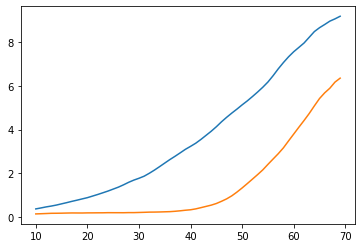

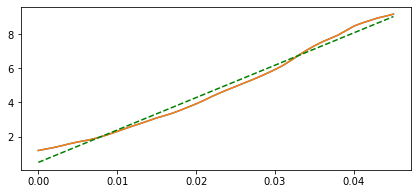

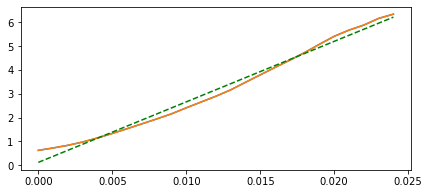

0.22766137527833116
0.04878229740456872
0.08573565389598124
nan
0.22766137527833116
0.08573565389598124
          G301
0   189.699946
1   254.332513
2     0.785724
3          NaN
4     0.623407
5     0.557865
6    -0.340709
7    14.000000
8    35.000000
9   -60.000000
10  240.056000
11  130.041000
12   45.828890
13    8.000000


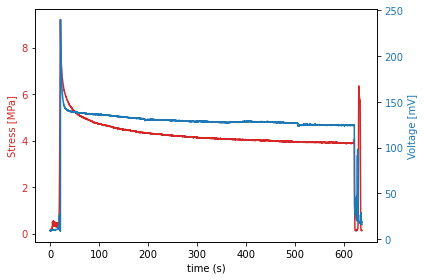

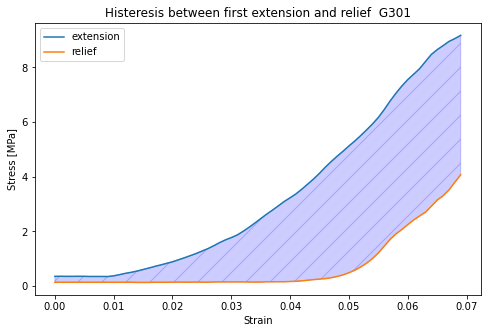

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G302/
[443, 12606, 12426]


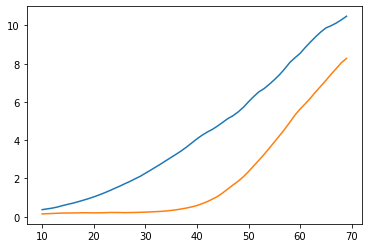

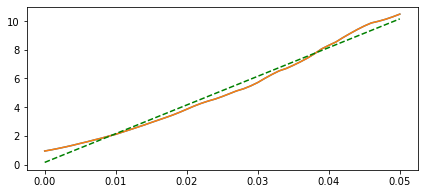

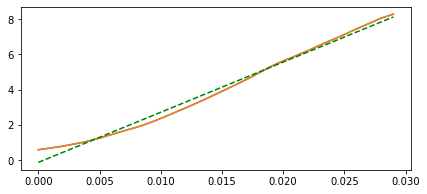

0.26599971220164986
0.07720323947026246
0.12434865412644996
nan
0.26599971220164986
0.12434865412644996
          G302
0   199.941069
1   284.625468
2     0.709762
3          NaN
4     0.532523
5     0.478455
6    -0.423547
7     9.000000
8    30.000000
9   -70.000000
10  122.846000
11   33.770000
12   72.510297
13    8.000000


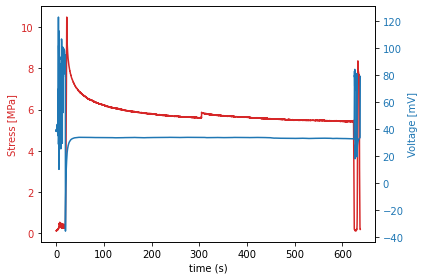

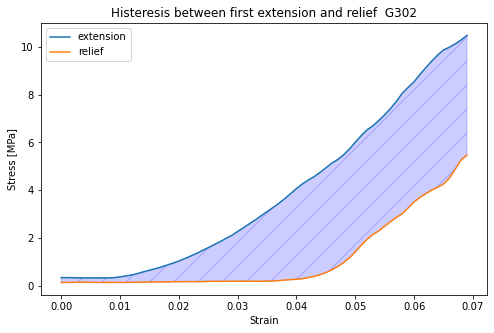

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G303/
[441, 12604, 12424]


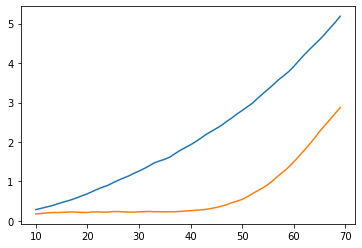

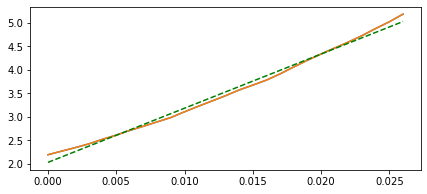

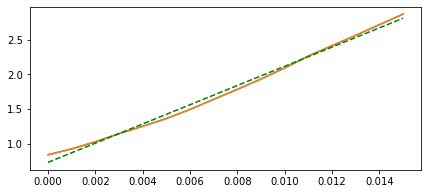

0.13071114381362492
0.03143259493306873
0.041403917110624994
nan
0.13071114381362492
0.041403917110624994
          G303
0   115.423244
1   138.953337
2     0.759526
3          NaN
4     0.683241
5     0.519389
6    -0.203859
7    33.000000
8    44.000000
9   -25.000000
10   95.792000
11    2.635000
12   97.249248
13    8.000000


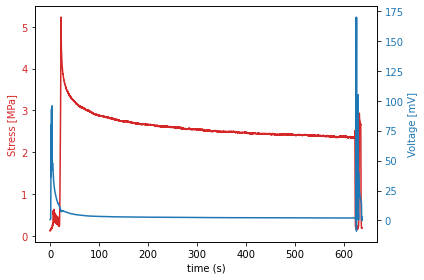

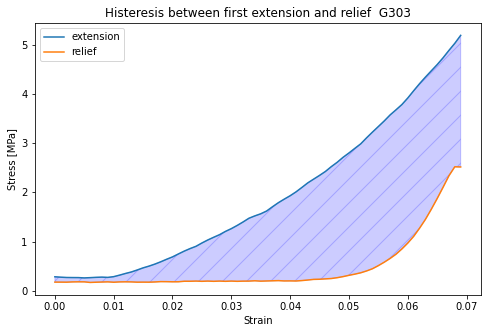

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G304/
[456, 12619, 12439]


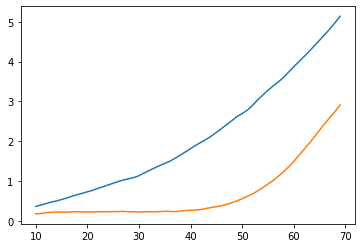

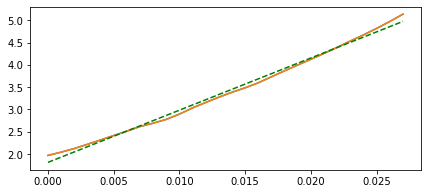

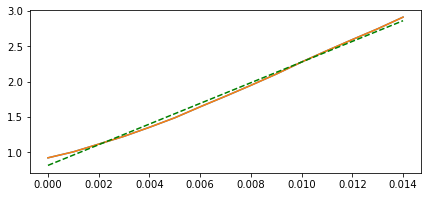

0.1278431761774437
0.03302128507177497
0.04141394540372499
nan
0.1278431761774437
0.04141394540372499
          G304
0   117.089585
1   145.864457
2     0.741705
3          NaN
4     0.676057
5     0.471093
6    -0.245751
7    32.000000
8    45.000000
9   -28.888889
10   47.383000
11    7.768000
12   83.605935
13    8.000000


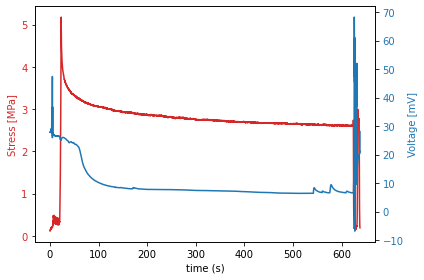

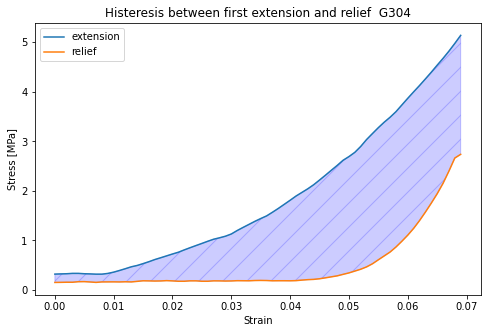

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G305/
próbka: G305  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G306/
[529, 12693, 12513]


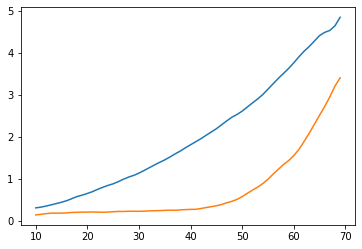

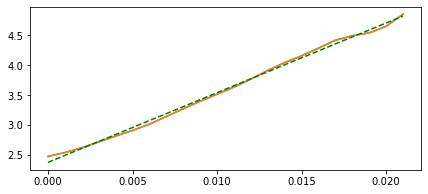

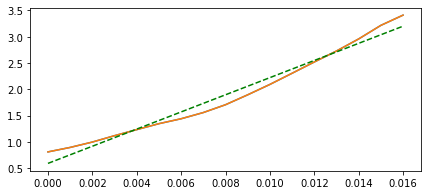

0.12406091275708747
0.028759386166268722
0.04443690452197498
nan
0.12406091275708747
0.04443690452197498
          G306
0   116.497430
1   163.006493
2     0.768183
3          NaN
4     0.641814
5     0.488871
6    -0.399228
7    38.000000
8    43.000000
9   -11.627907
10   90.422000
11   39.685000
12   56.111345
13    8.000000


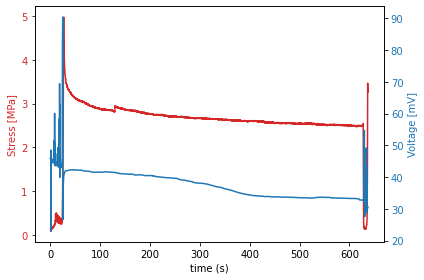

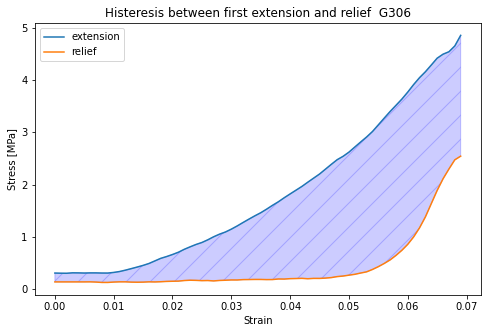

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G307/
[419, 12582, 12402]


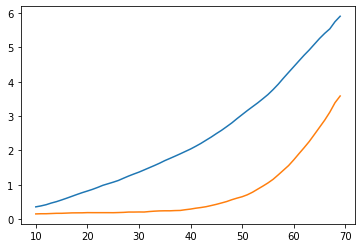

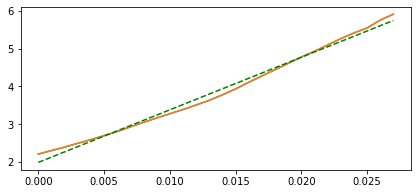

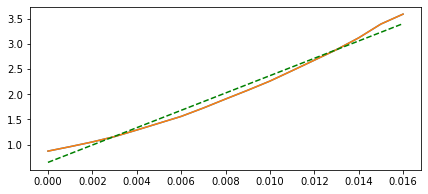

0.14519055045962495
0.028368438774874983
0.046330721041906234
nan
0.14519055045962495
0.046330721041906234
          G307
0   139.145862
1   171.899979
2     0.804612
3          NaN
4     0.680897
5     0.562462
6    -0.235394
7    32.000000
8    43.000000
9   -25.581395
10   12.755000
11   -3.798000
12  129.776558
13    8.000000


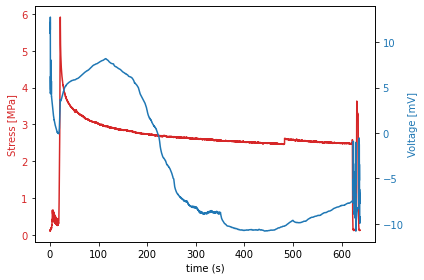

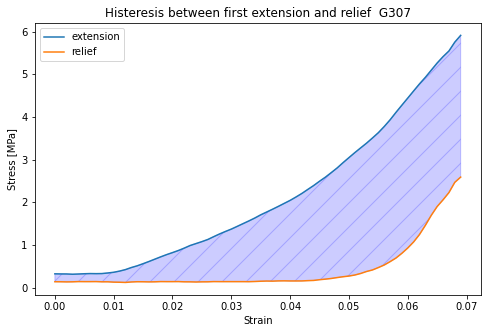

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G308/
[480, 12644, 12464]


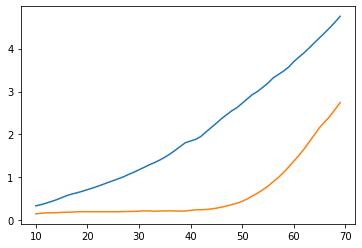

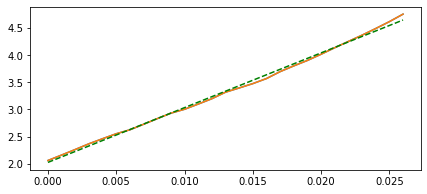

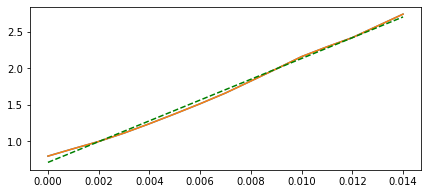

0.12527460243711244
0.023272681355743733
0.03736024475403124
nan
0.12527460243711244
0.03736024475403124
          G308
0   100.786226
1   142.544741
2     0.814227
3          NaN
4     0.701773
5     0.548508
6    -0.414328
7    33.000000
8    45.000000
9   -26.666667
10  161.819000
11   30.313000
12   81.267342
13    8.000000


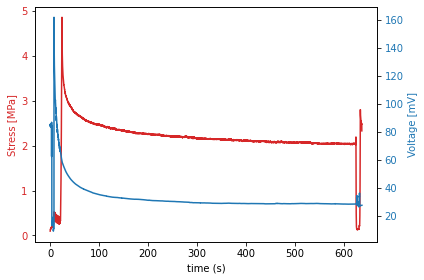

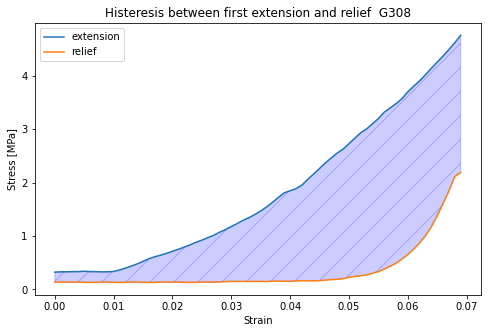

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G309/
[419, 12582, 12402]


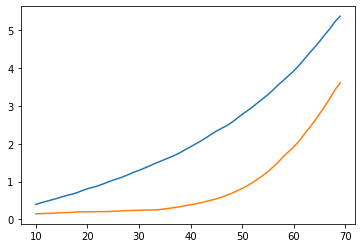

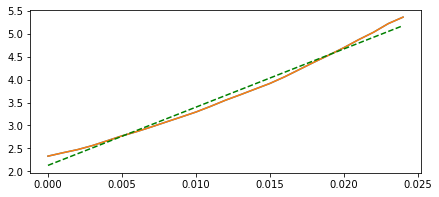

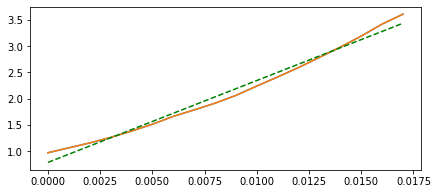

0.1338532398044062
0.034844163022443725
0.05145103049863749
nan
0.1338532398044062
0.05145103049863749
          G309
0   126.966671
1   155.751770
2     0.739684
3          NaN
4     0.615616
5     0.450290
6    -0.226714
7    35.000000
8    42.000000
9   -16.666667
10   32.145000
11   16.258000
12   49.422927
13    8.000000


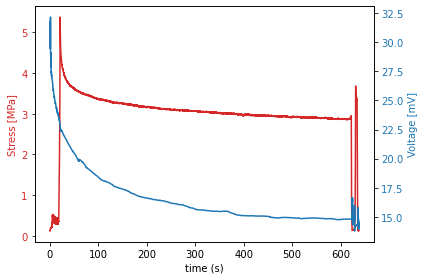

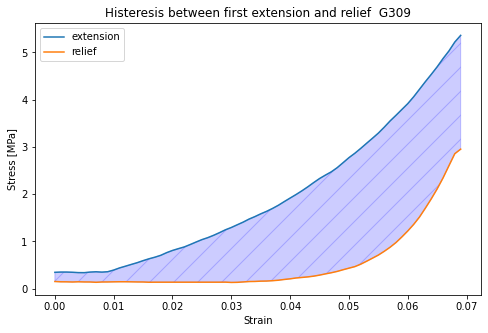

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G310/
[480, 12643, 12463]


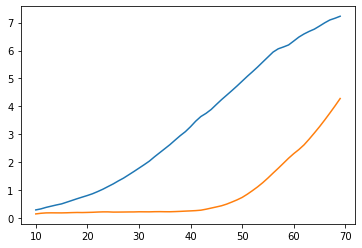

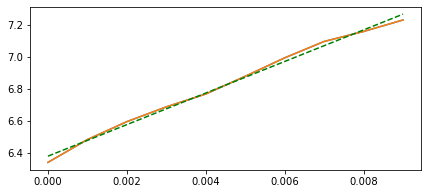

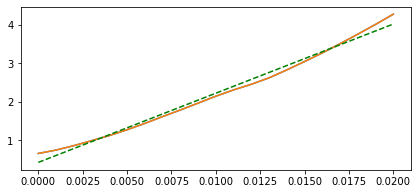

0.20494161039154363
0.037388554388318736
0.05574106357063123
nan
0.20494161039154363
0.05574106357063123
          G310
0    98.404264
1   180.308744
2     0.817565
3          NaN
4     0.728015
5     0.598326
6    -0.832327
7    50.000000
8    39.000000
9    28.205128
10    8.960000
11    8.880000
12    0.892857
13    8.000000


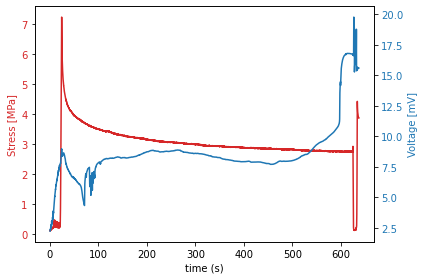

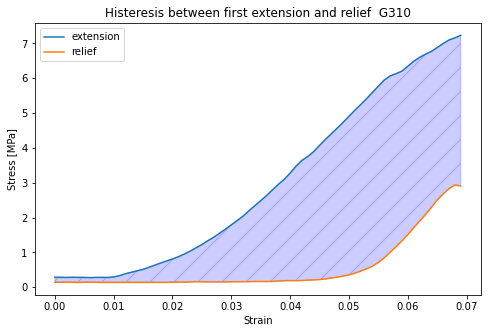

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G311/
próbka: G311  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G312/
próbka: G312  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G501/
[438, 12602, 12422]


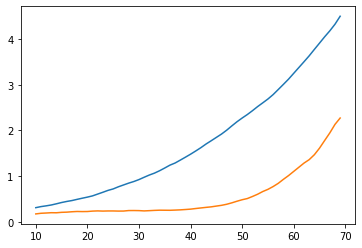

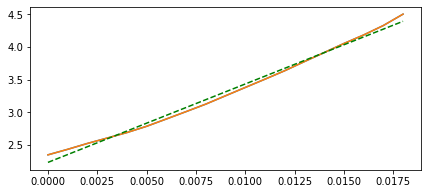

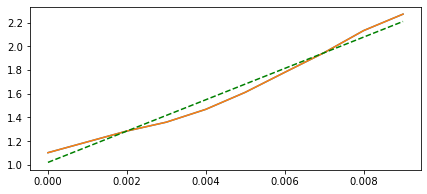

0.1066318326716687
0.021083232478368734
0.03387038899728749
0.013665975537956242
0.1066318326716687
0.03387038899728749
          G501
0   120.022836
1   132.201026
2     0.802280
3     0.596521
4     0.682361
5     0.633630
6    -0.101466
7    41.000000
8    50.000000
9   -18.000000
10    3.944000
11   15.275000
12 -287.297160
13    8.000000


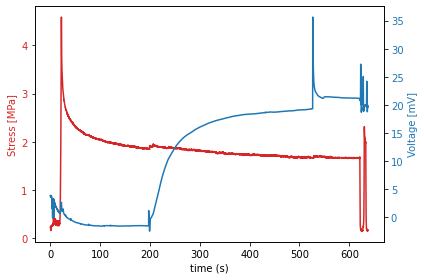

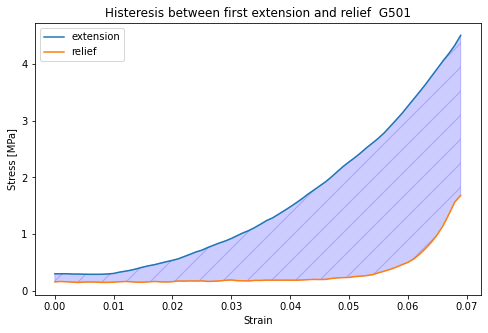

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G502/
[419, 12582, 12402]


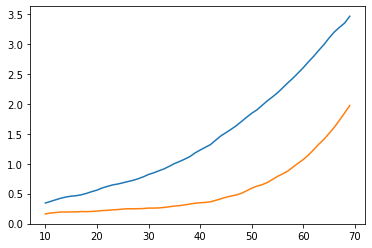

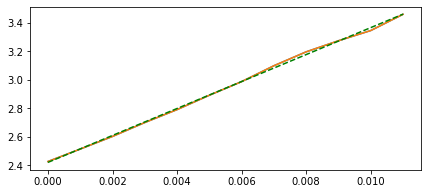

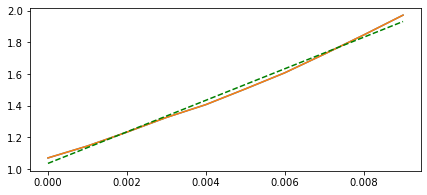

0.08928374330914997
0.023669014413818742
0.03449604422721874
nan
0.08928374330914997
0.03449604422721874
         G502
0   94.503796
1   99.461926
2    0.734901
3         NaN
4    0.613636
5    0.550036
6   -0.052465
7   48.000000
8   50.000000
9   -4.000000
10  28.188000
11  28.429000
12  -0.854974
13   8.000000


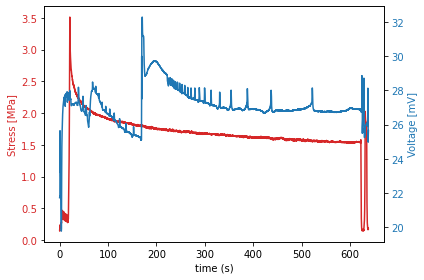

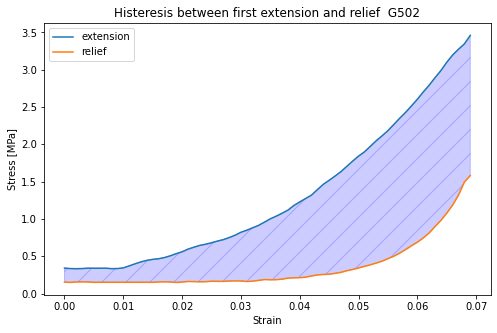

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G503/
[431, 12595, 12415]


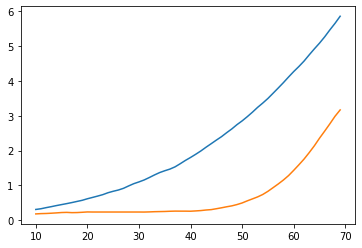

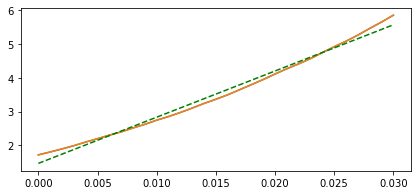

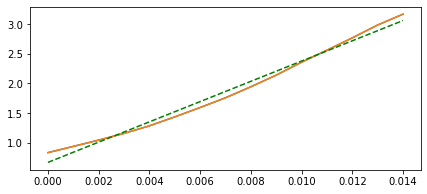

0.13388997287414373
0.029314104806556236
0.041516799736849984
nan
0.13388997287414373
0.041516799736849984
          G503
0   136.859925
1   170.962257
2     0.781058
3          NaN
4     0.689919
5     0.531248
6    -0.249177
7    29.000000
8    45.000000
9   -35.555556
10   41.750000
11   37.163000
12   10.986826
13    8.000000


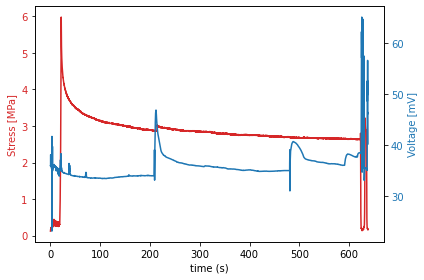

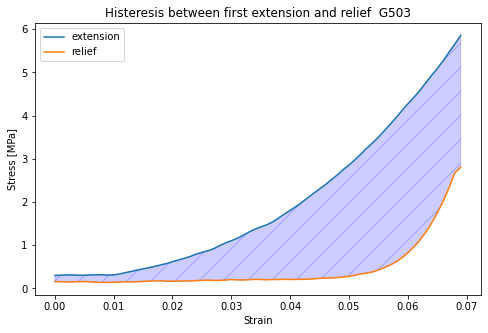

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G504/
[506, 12669, 12489]


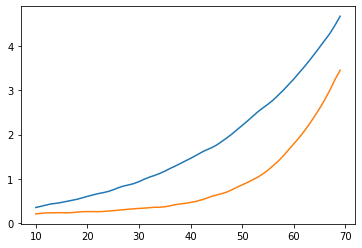

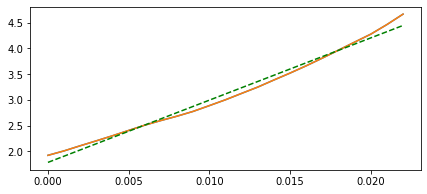

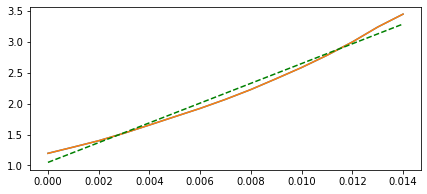

0.10782958195347497
0.03306913573296873
0.05289030444490623
nan
0.10782958195347497
0.05289030444490623
          G504
0   120.902936
1   159.854996
2     0.693320
3          NaN
4     0.509501
5     0.498716
6    -0.322176
7    37.000000
8    45.000000
9   -17.777778
10   59.706000
11   44.618000
12   25.270492
13    8.000000


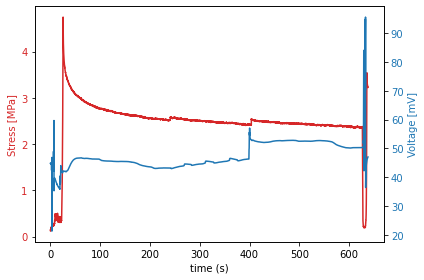

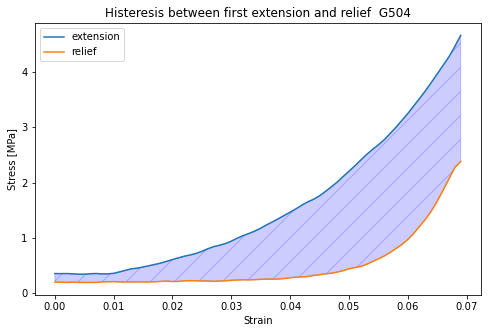

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G505/
[407, 12570, 12390]


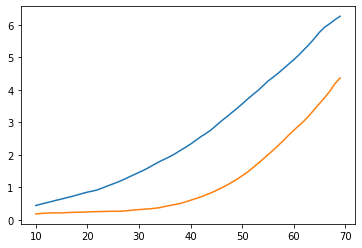

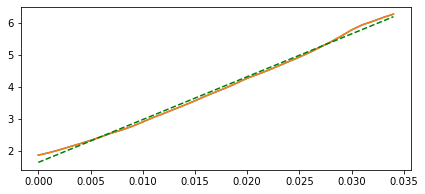

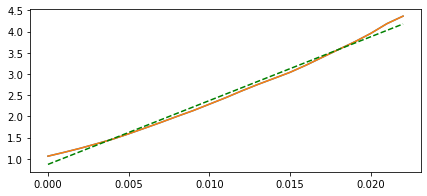

0.16285935165419366
0.04989816881397497
0.07181686855278123
nan
0.16285935165419366
0.07181686855278123
          G505
0   133.429692
1   150.444678
2     0.693612
3          NaN
4     0.559025
5     0.451160
6    -0.127520
7    25.000000
8    37.000000
9   -32.432432
10   67.507000
11   29.998000
12   55.563127
13    8.000000


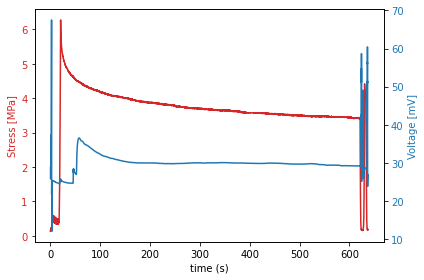

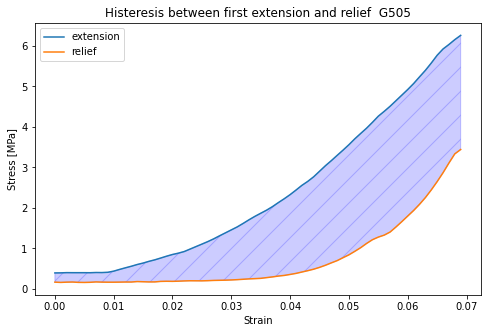

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G506/
[455, 12619, 12439]


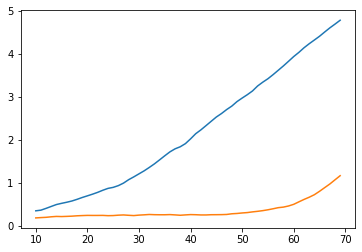

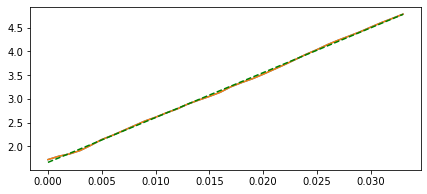

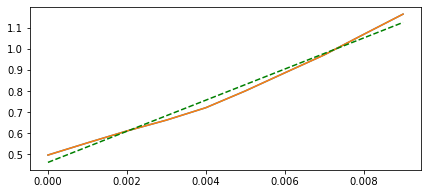

0.13272537050387495
0.017391623964312486
0.022295313884587494
nan
0.13272537050387495
0.022295313884587494
          G506
0    94.576597
1    73.591934
2     0.868965
3          NaN
4     0.832019
5     0.779815
6     0.221880
7    26.000000
8    50.000000
9   -48.000000
10  145.810000
11   54.712000
12   62.477196
13    8.000000


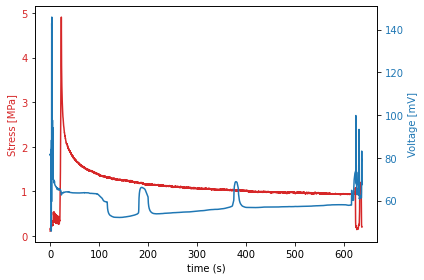

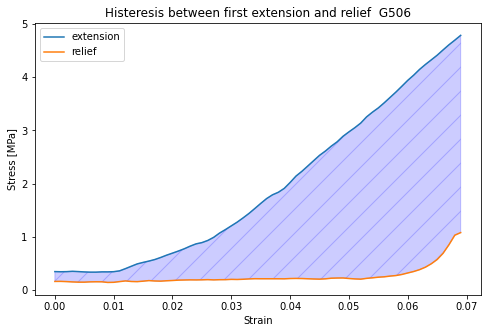

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G507/
[419, 12582, 12402]


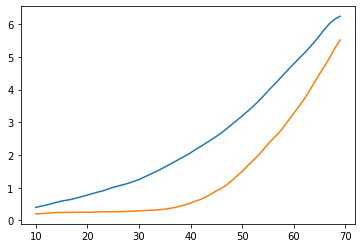

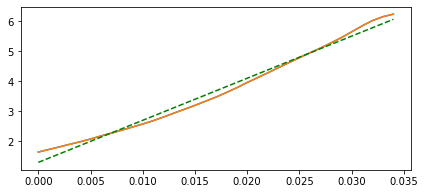

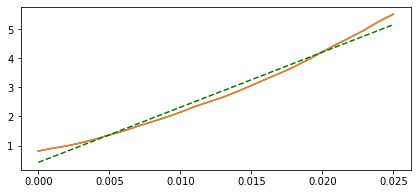

0.15149122464178746
0.047978183433487476
0.08267042366322497
nan
0.15149122464178746
0.08267042366322497
          G507
0   140.689724
1   189.512823
2     0.683294
3          NaN
4     0.454289
5     0.408572
6    -0.347027
7    25.000000
8    34.000000
9   -26.470588
10   75.245000
11   32.522000
12   56.778523
13    8.000000


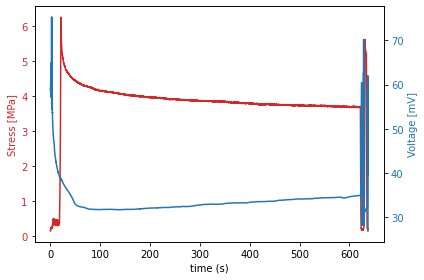

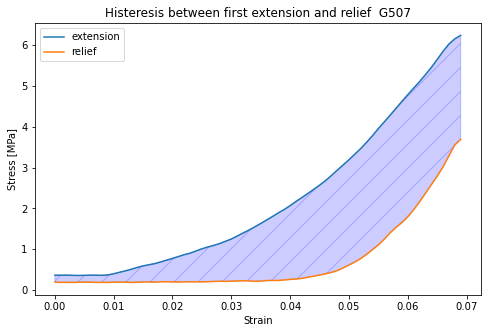

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G508/
próbka: G508  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G509/
próbka: G509  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G510/
[430, 12594, 12414]


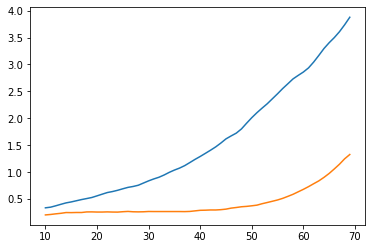

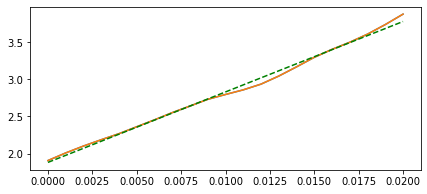

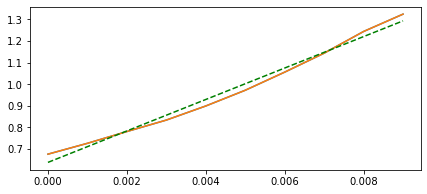

0.0955064908503437
0.02441201573213748
0.026289352416499986
nan
0.0955064908503437
0.026289352416499986
          G510
0    94.819294
1    72.753703
2     0.744394
3          NaN
4     0.724738
5     0.588013
6     0.232712
7    39.000000
8    50.000000
9   -22.000000
10  168.458000
11   59.096000
12   64.919446
13    8.000000


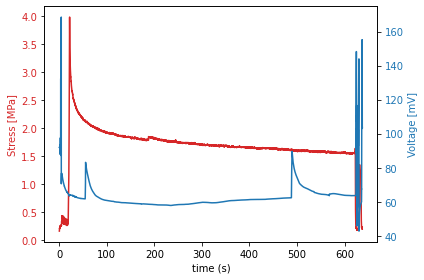

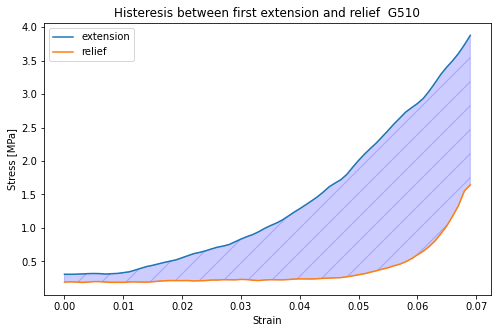

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G511/
[467, 12631, 12451]


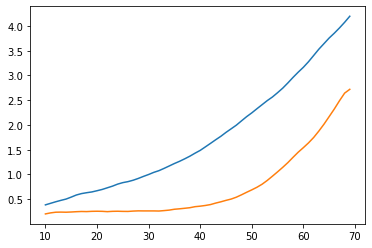

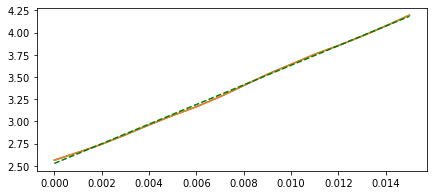

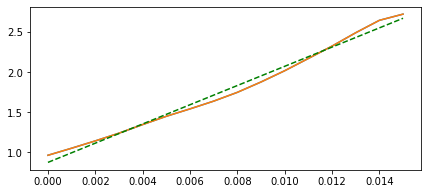

0.1080729002401187
0.032748587228224976
0.04455013433478748
nan
0.1080729002401187
0.04455013433478748
          G511
0   110.406853
1   119.496030
2     0.696977
3          NaN
4     0.587777
5     0.442116
6    -0.082324
7    44.000000
8    44.000000
9     0.000000
10   50.080000
11   35.210000
12   29.692492
13    8.000000


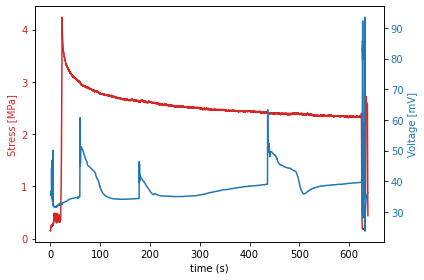

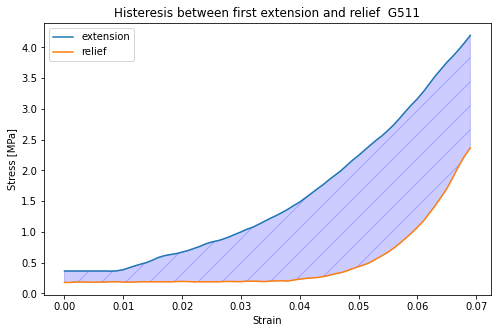

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G512/
[481, 12645, 12465]


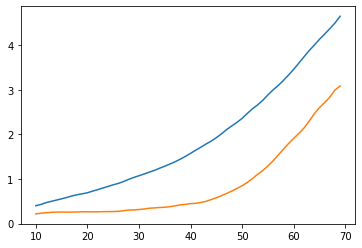

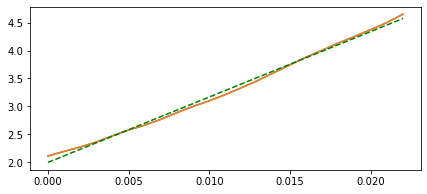

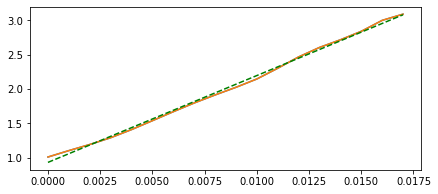

0.11599469982586244
0.036030077144793726
0.052981495670218745
nan
0.11599469982586244
0.052981495670218745
          G512
0   117.265760
1   126.217808
2     0.689382
3          NaN
4     0.543242
5     0.461451
6    -0.076340
7    37.000000
8    42.000000
9   -11.904762
10  112.191000
11   98.923000
12   11.826261
13    8.000000


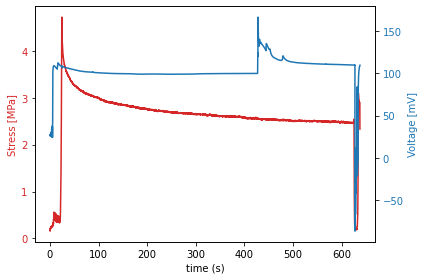

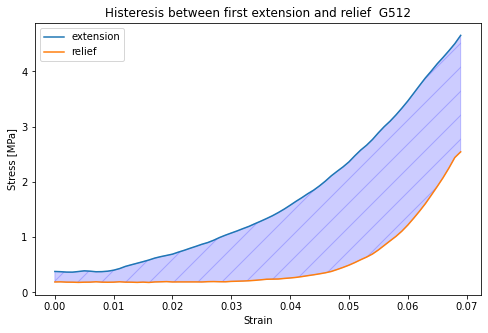

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G701/
próbka: G701  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G702/
[455, 12618, 12438]


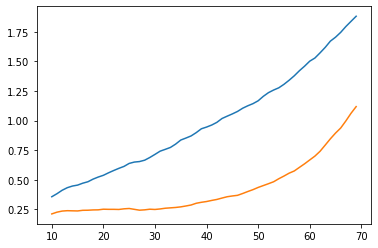

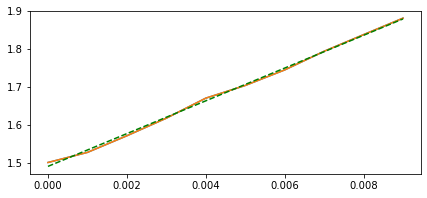

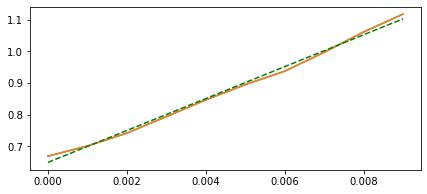

0.06148345129643747
0.020237376669256242
0.02667028148296249
nan
0.06148345129643747
0.02667028148296249
          G702
0    43.074540
1    50.584413
2     0.670848
3          NaN
4     0.566220
5     0.503515
6    -0.174346
7    50.000000
8    50.000000
9     0.000000
10  110.118000
11   45.084000
12   59.058465
13    8.000000


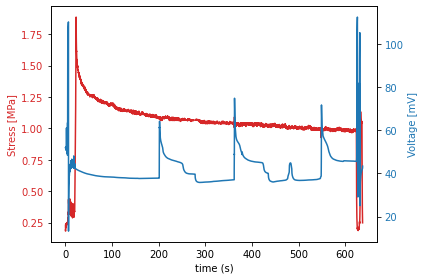

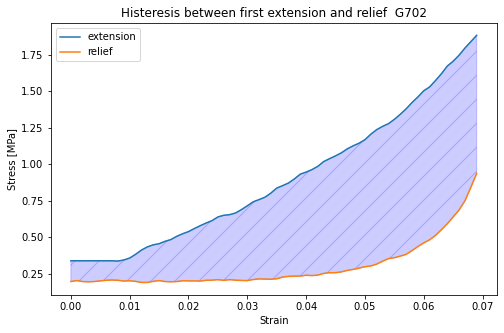

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G703/
[468, 12632, 12452]


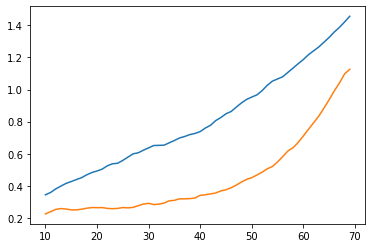

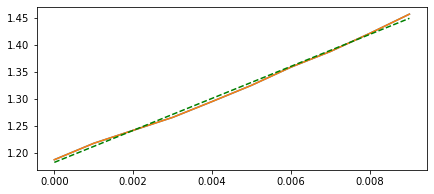

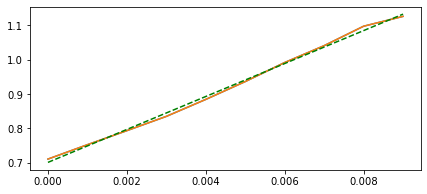

0.05106116105344998
0.01853221587161874
0.028092704476462494
nan
0.05106116105344998
0.028092704476462494
          G703
0    29.674822
1    47.984850
2     0.637058
3          NaN
4     0.449822
5     0.538967
6    -0.617022
7    50.000000
8    50.000000
9     0.000000
10  120.806000
11   57.818000
12   52.139794
13    8.000000


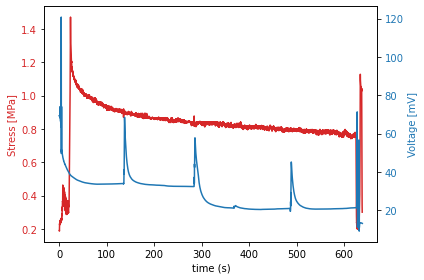

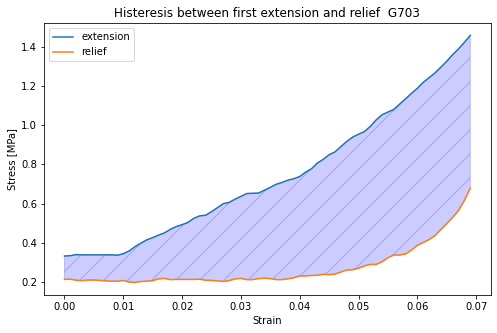

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G704/
[454, 12618, 12438]


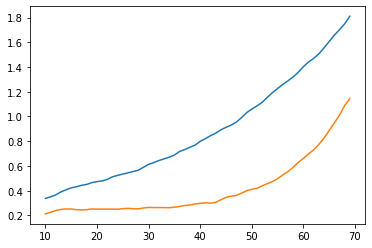

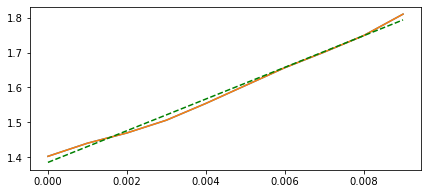

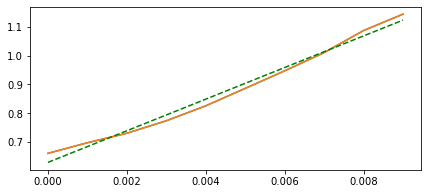

0.055369829503049986
0.01935639925262499
0.02617021375705624
nan
0.055369829503049986
0.02617021375705624
         G704
0   45.404862
1   54.938848
2    0.650416
3         NaN
4    0.527356
5    0.533924
6   -0.209977
7   50.000000
8   50.000000
9    0.000000
10  94.017000
11  13.175000
12  85.986577
13   8.000000


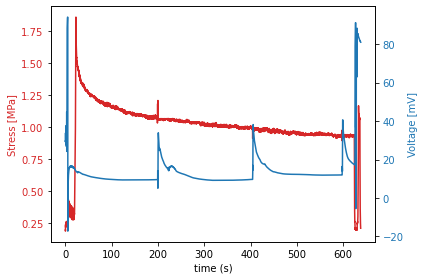

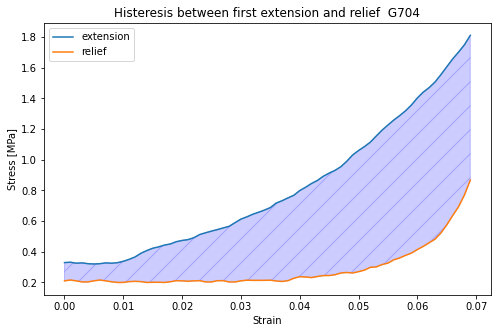

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G705/
próbka: G705  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G706/
[504, 12667, 12487]


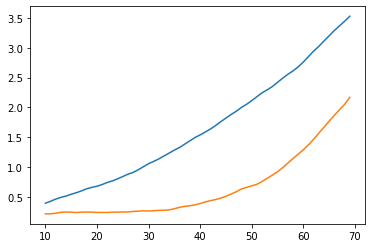

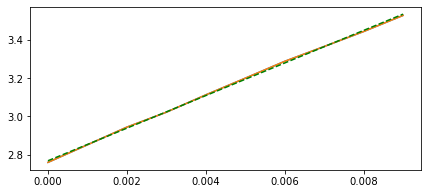

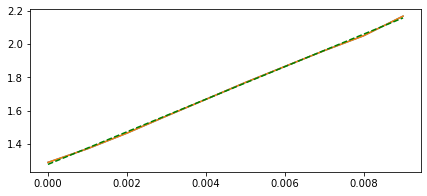

0.10127574836189368
0.02487786105292498
0.04012268352208124
nan
0.10127574836189368
0.04012268352208124
         G706
0   85.087038
1   97.780918
2    0.754355
3         NaN
4    0.603827
5    0.542589
6   -0.149187
7   50.000000
8   50.000000
9    0.000000
10  69.573000
11  65.077000
12   6.462277
13   8.000000


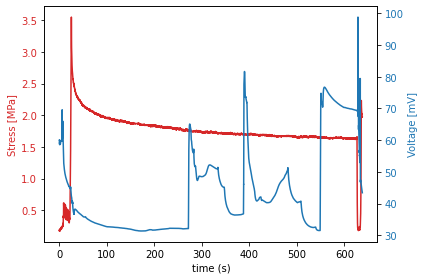

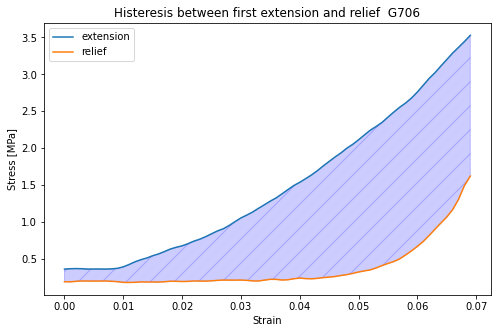

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G707/
[441, 12605, 12425]


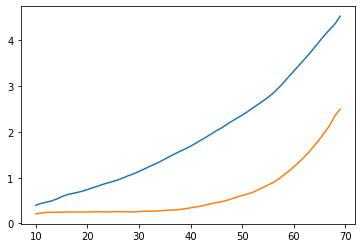

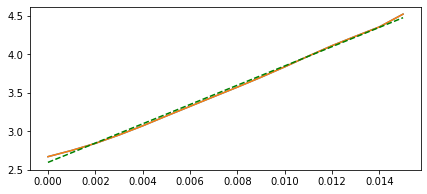

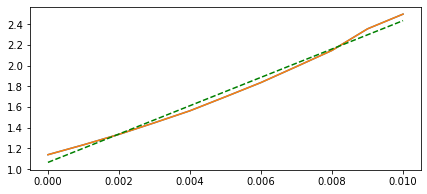

0.11601064570744996
0.024130005937174983
0.03930422936796248
nan
0.11601064570744996
0.03930422936796248
          G707
0   125.321661
1   136.892058
2     0.792002
3          NaN
4     0.661202
5     0.585398
6    -0.092326
7    44.000000
8    49.000000
9   -10.204082
10   91.880000
11   50.702000
12   44.817153
13    8.000000


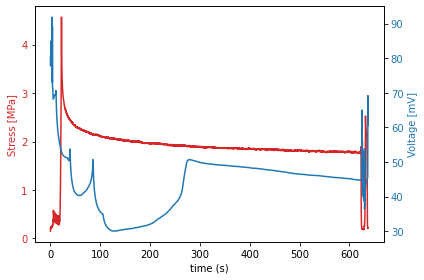

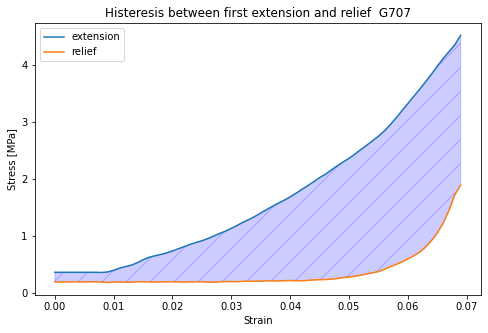

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G708/
[442, 12606, 12426]


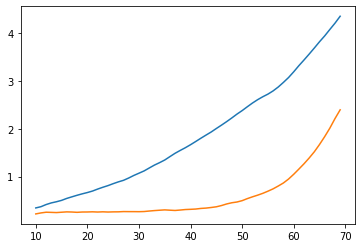

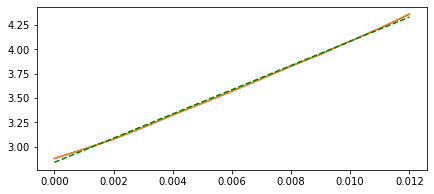

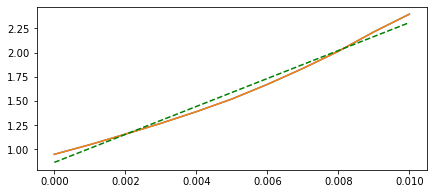

0.11206747826193744
0.02326176097285624
0.03578893146344999
nan
0.11206747826193744
0.03578893146344999
          G708
0   124.491296
1   144.739647
2     0.792431
3          NaN
4     0.680648
5     0.591504
6    -0.162649
7    47.000000
8    49.000000
9    -4.081633
10   74.496000
11   89.052000
12  -19.539304
13    8.000000


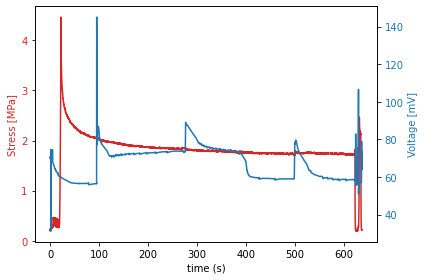

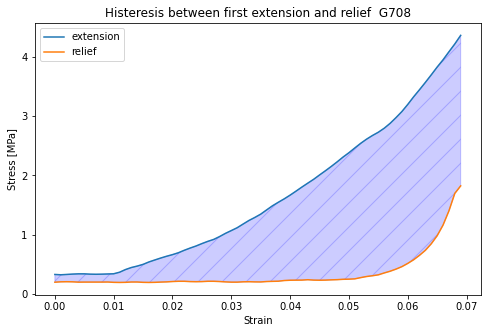

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G709/
próbka: G709  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G710/
[467, 12631, 12451]


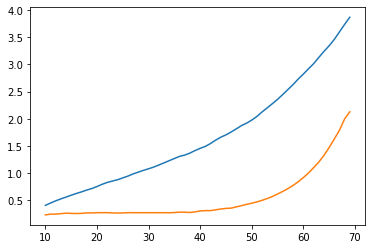

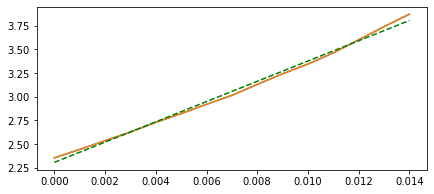

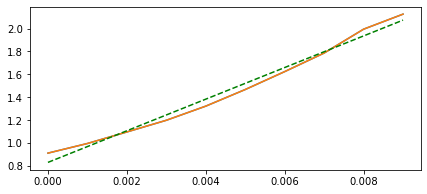

0.10193168229857495
0.020376583932762492
0.03265166830015624
nan
0.10193168229857495
0.03265166830015624
          G710
0   106.924507
1   138.160300
2     0.800096
3          NaN
4     0.679671
5     0.646924
6    -0.292129
7    45.000000
8    50.000000
9   -10.000000
10  114.464000
11   47.200000
12   58.764328
13    8.000000


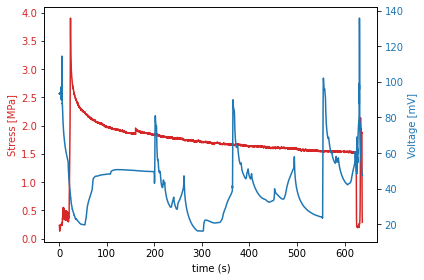

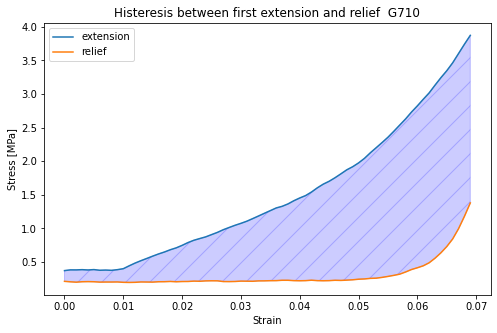

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G711/
próbka: G711  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G712/
[456, 12620, 12440]


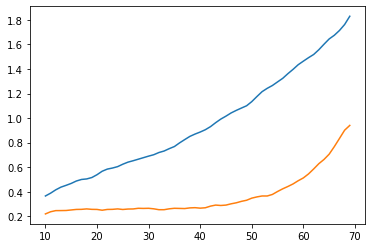

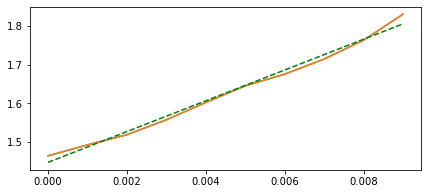

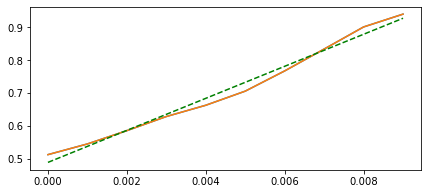

0.059857301480318724
0.017230555770949993
0.023192057913437484
nan
0.059857301480318724
0.023192057913437484
          G712
0    39.786466
1    48.807943
2     0.712139
3          NaN
4     0.612544
5     0.639541
6    -0.226747
7    50.000000
8    50.000000
9     0.000000
10  137.872000
11   63.357000
12   54.046507
13    8.000000


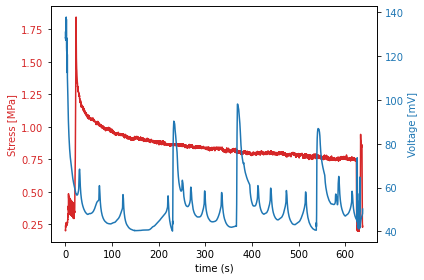

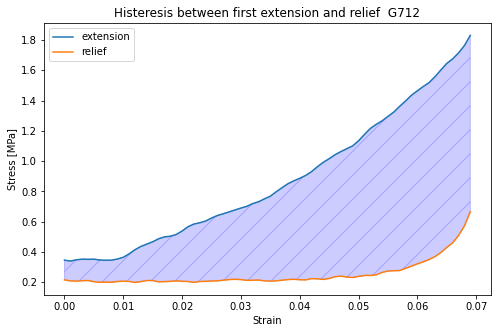

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G901/
próbka: G901  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G902/
próbka: G902  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G903/
próbka: G903  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G904/
próbka: G904  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G905/
próbka: G905  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G906/
próbka: G906  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G907/
próbka: G907  jest uszkodzona/odrzucona

In [10]:
d =  {j: dataProcessing(j) for j in numberOfGroup}
print(d)
#dfData = pd.DataFrame.from_dict(d, orient="index")
#print(dfData)

In [7]:
#print(dfData) col_one_list = df['one'].tolist()
#dfData.iloc[:, dfData.columns.get_level_values(0)=='1'] 
#print(d)
l=list(d.values())

def returnDfOfGroups(l,parametr):
    newDF=pd.DataFrame({'A' : []})
    j=0
    for i in numberOfGroup:  
        newDF=pd.concat([newDF.reindex(newDF.index), pd.DataFrame(l[j][parametr].tolist(), columns=['G'+str(i)])], axis=1)
        j=j+1
    newDF.drop('A', inplace=True, axis=1)
    return newDF


parameters={'Young_1':0,'Young_2':1,'AreaOfHis_1':2,'AreaOfHis_2':3,
            'AreaOfHis_pseudo':4,'DropOfStress':5,'DropOfYoung':6,
            'InflectionPoint_1':7,'InflectionPoint_2':8,'InflectionPointDrop':9,
            'Volt_1':10,'Volt_2':11,'VoltDrop':12,'Area':13}

#print(returnDfOfGroups(l,parameters['Young_1']))

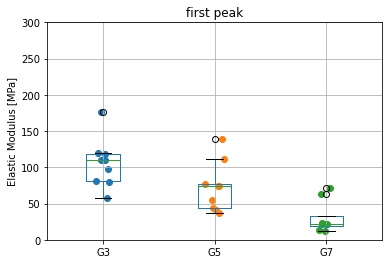

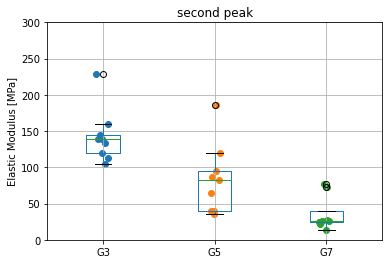

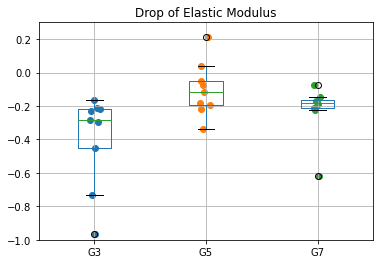

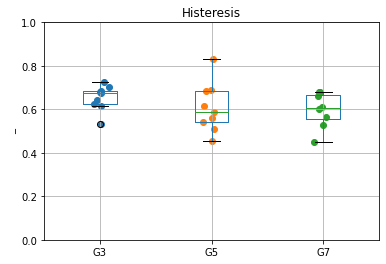

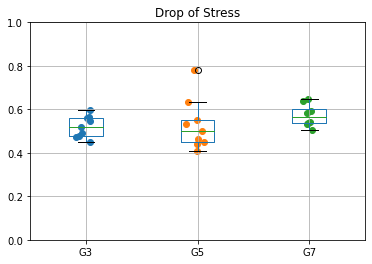

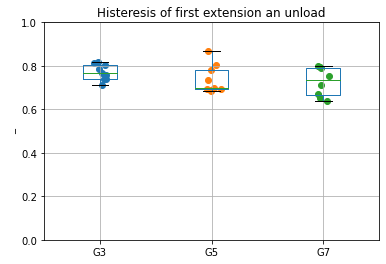

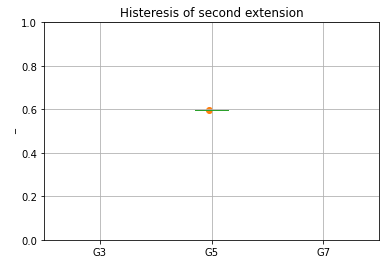

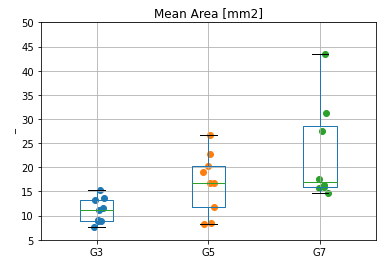

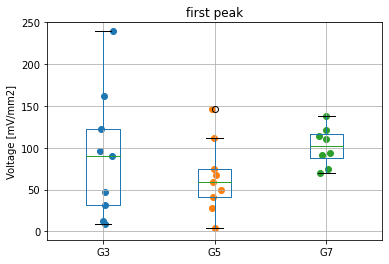

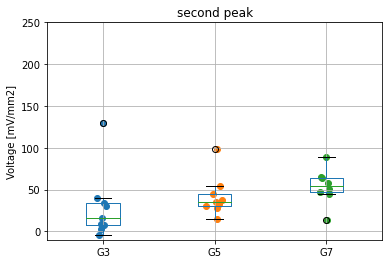

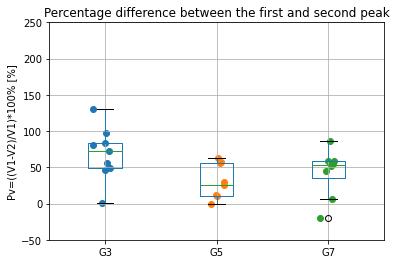

In [8]:
ploting=Ploting()
# box_scatter_plot(df,ylabel,               title,     ylim)    
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_1']),'Young_1','Elastic Modulus [MPa]','first peak',0,300)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_2']),'Young_2','Elastic Modulus [MPa]','second peak',0,300)
                 
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung','','Drop of Elastic Modulus',-1,0.3)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo','_','Histeresis',0,1)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress','','Drop of Stress',0,1)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1','_','Histeresis of first extension an unload',0,1)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_2']),'AreaOfHis_2','_','Histeresis of second extension',0,1)


ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Area']),'Area','_','Mean Area [mm2]',5,50)

'''
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_1']),'InflectionPoint_1','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_2']),'InflectionPoint_2','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPointDrop']),'InflectionPointDrop','[mm]','Drop of Stress Deriative',0,200)
'''

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Volt_1']),'Volt_1','Voltage [mV/mm2]','first peak',-10,250)#30)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Volt_2']),'Volt_2','Voltage [mV/mm2]','second peak',-10,250)#30)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['VoltDrop']),'VoltDrop','Pv=((V1-V2)/V1)*100% [%]','Percentage difference between the first and second peak',-50,250)

In [9]:

returnDfOfGroups(l,parameters['Area']).describe()


,G3,G5,G7
count,9.000000,9.000000,8.000000
mean,11.079360,16.781572,22.846220
std,2.609112,6.302198,10.385831
min,7.661528,8.336002,14.672424
25%,8.922498,11.698597,15.906380
50%,11.222503,16.851324,17.013139
75%,13.313420,20.325688,28.486254
max,15.243811,26.654672,43.531602


first peak
pvalue = 0.00022434404703875139 F=12.378641679589958

p<0.05

Anderson bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.032421  0.001000
G5  0.032421  1.000000  0.004772
G7  0.001000  0.004772  1.000000
Ttest bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.053892  0.000093
G5  0.053892  1.000000  0.010815
G7  0.000093  0.010815  1.000000
Ttest z poprawką Bonferroniego
          G3        G5        G7
G3  1.000000  0.161675  0.000278
G5  0.161675  1.000000  0.032445
G7  0.000278  0.032445  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value floored: true value smaller than 0.001
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


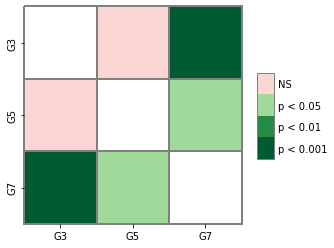

second peak
pvalue = 3.4949786492542046e-05 F=16.568836011737247

p<0.05

Anderson bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.005735  0.001000
G5  0.005735  1.000000  0.004772
G7  0.001000  0.004772  1.000000
Ttest bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.009640  0.000005
G5  0.009640  1.000000  0.025539
G7  0.000005  0.025539  1.000000
Ttest z poprawką Bonferroniego
          G3        G5        G7
G3  1.000000  0.028919  0.000015
G5  0.028919  1.000000  0.076618
G7  0.000015  0.076618  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value floored: true value smaller than 0.001
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


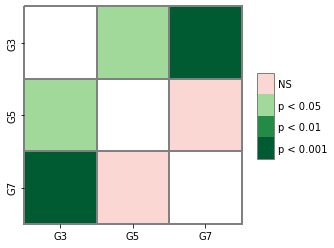

Drop off stress
pvalue = 0.36225393966206937 F=1.0615874408545323

niby histereza
pvalue = 0.37791354850334513 F=1.0154457462763873

spadek Modulow
pvalue = 0.02393323282660686 F=4.409416197791679

p<0.05

Anderson bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.007867  0.035574
G5  0.007867  1.000000  0.250000
G7  0.035574  0.250000  1.000000
Ttest bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.014539  0.153720
G5  0.014539  1.000000  0.139957
G7  0.153720  0.139957  1.000000
Ttest z poprawką Bonferroniego
          G3        G5        G7
G3  1.000000  0.043618  0.461161
G5  0.043618  1.000000  0.419870
G7  0.461161  0.419870  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


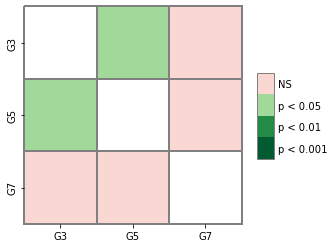

His 1
pvalue = 0.26604390191458394 F=1.4033328538638448

His 2
pvalue = 0.008084157109681958 F=5.984074369821924

p<0.05

Anderson bez poprawki Bonferroniego
          G3        G5     G7
G3  1.000000  0.032004  0.001
G5  0.032004  1.000000  0.250
G7  0.001000  0.250000  1.000
Ttest bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.023298  0.004895
G5  0.023298  1.000000  0.160674
G7  0.004895  0.160674  1.000000
Ttest z poprawką Bonferroniego
          G3        G5        G7
G3  1.000000  0.069894  0.014686
G5  0.069894  1.000000  0.482023
G7  0.014686  0.482023  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value floored: true value smaller than 0.001
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]
D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


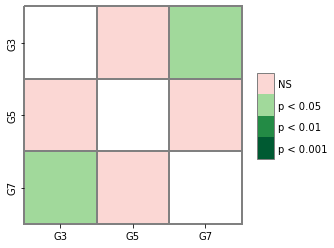

Area
Volt_1
pvalue = 0.35741530817295336 F=1.0762843755283535

Volt_2
pvalue = 0.2701205049769287 F=1.3862816219346263

VoltDrop
pvalue = 0.10663928180926635 F=2.4709770255184895

p<0.05

Anderson bez poprawki Bonferroniego
         G3       G5    G7
G3  1.00000  0.02341  0.25
G5  0.02341  1.00000  0.25
G7  0.25000  0.25000  1.00
Ttest bez poprawki Bonferroniego
          G3        G5        G7
G3  1.000000  0.075914  0.150281
G5  0.075914  1.000000  0.262797
G7  0.150281  0.262797  1.000000
Ttest z poprawką Bonferroniego
          G3        G5        G7
G3  1.000000  0.227742  0.450844
G5  0.227742  1.000000  0.788390
G7  0.450844  0.788390  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


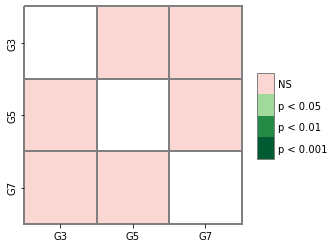

In [10]:
print('first peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_1']),'Young_1')
print('second peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_2']),'Young_2')
print('Drop off stress')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress')
print('niby histereza')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo')
print('spadek Modulow')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung')
print('His 1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1')
print('His 2')
#StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_2']))
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Area']),'Area')
print('Area')
'''
print('InflectionPoint_1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_1']))
print('InflectionPoint_2')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_2']))
print('InflectionPointDrop')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPointDrop']))
'''

print('Volt_1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Volt_1']),'Volt_1')
print('Volt_2')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Volt_2']),'Volt_2')
print('VoltDrop')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['VoltDrop']),'VoltDrop')
